In [1]:
%matplotlib inline

In [145]:
import numpy as np                     # Numerical algorithms on arrays
import cv2                             # OpenCV
from matplotlib import pyplot as plt   # Plot library
import matplotlib.cm as cm             # Image color map 
import tools                           # A few helpers to plot multiple images
from PIL import Image                  # For rescaling images
from ipywidgets import interact, fixed # Interact with images

In [146]:
img_link = 'images/sudoku/sudoku_00399.png'

## Prefiltering

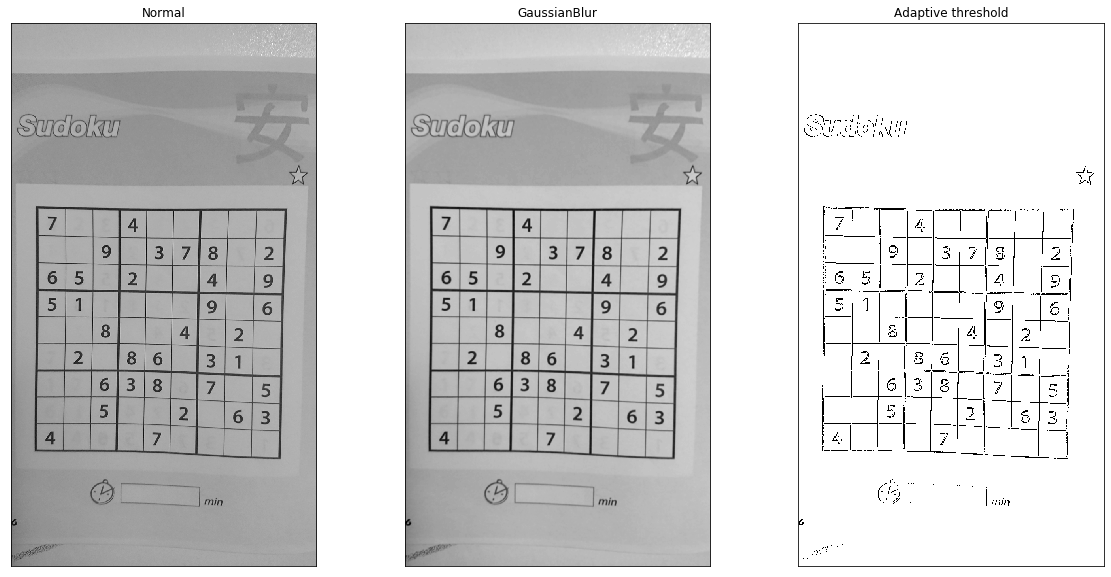

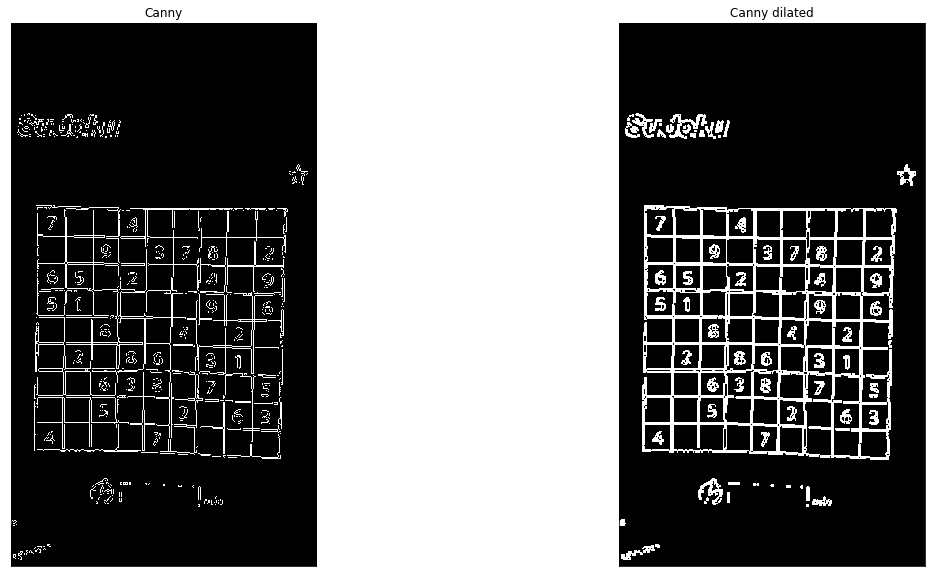

In [147]:
# prefiltrering and scaling 

img = cv2.imread(img_link, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(img_link, cv2.IMREAD_COLOR)

b,g,r = cv2.split(img_color)
img_color = cv2.merge( [r,g,b])

iGausKernelSize = 5
imgFilt = cv2.GaussianBlur(img, (iGausKernelSize, iGausKernelSize), 0)

imgThresh = cv2.adaptiveThreshold(imgFilt, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY, 3, 5)


iReducFactor = 2
iStart = iReducFactor // 2
imgReduc = imgThresh[iStart::iReducFactor, iStart::iReducFactor]
   
# compute the median of the single channel pixel intensities
med = np.median(imgReduc)
 
# apply automatic Canny edge detection using the computed median
sigma = 0.3
loThreshold = int( max( 0, (1.0 - sigma) * med))
hiThreshold = int( min( 255, (1.0 + sigma) * med))

edges = cv2.Canny(imgReduc, loThreshold, hiThreshold, apertureSize=3, L2gradient=False)
edges_dilated = cv2.dilate(edges, np.ones((2,2), dtype=np.uint8))

#cv2.imwrite('sudoku_gb.png', imgFilt)
#cv2.imwrite('sudoku_at.png', imgThresh)
#cv2.imwrite('sudoku_edges.png', edges)
#cv2.imwrite('sudoku_dilated.png', edges_dilated)

# plot all the images
tools.multiPlot( 1, 3, (img, imgFilt, imgThresh,),
                       ('Normal', 'GaussianBlur', 'Adaptive threshold',),
                        cmap_tuple=(cm.gray, cm.gray, cm.gray,))

tools.multiPlot(1, 2, (edges, edges_dilated), ('Canny', 'Canny dilated'), cmap_tuple=(cm.gray, cm.gray))

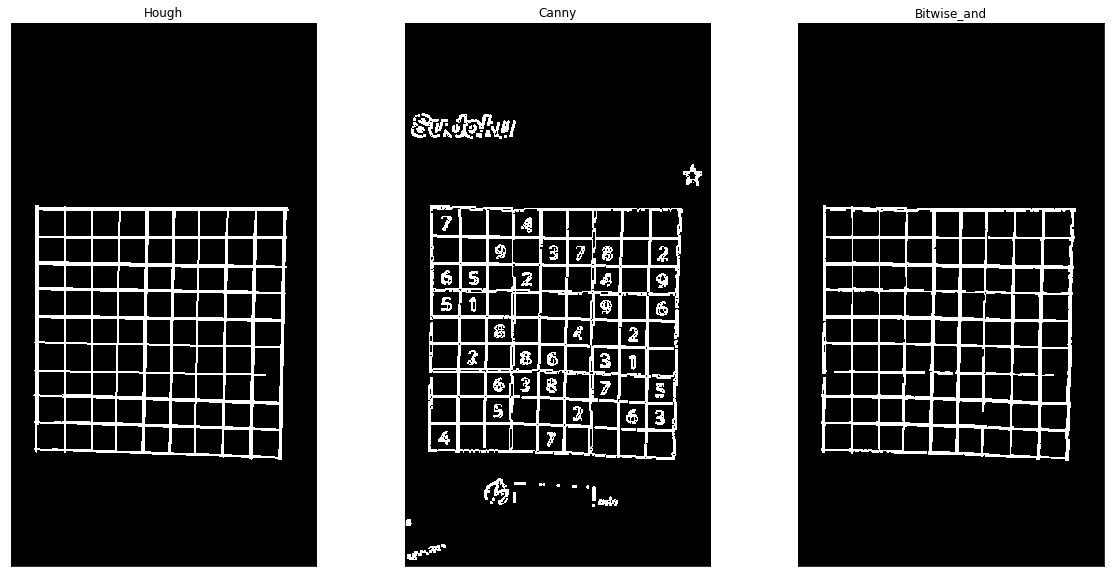

In [151]:
height, width = img.shape[:2]
mat = np.zeros((height,width))

minLineLength = 250
maxLineGap = 20

lines = cv2.HoughLinesP(edges_dilated,1,np.pi/180,100,np.array([]),minLineLength,maxLineGap)
for l in lines:
    for x1,y1,x2,y2 in l:
        cv2.line(mat,(2*x1,2*y1),(2*x2,2*y2),(255, 255, 255),3)
        cv2.line(img_color,(2*x1,2*y1),(2*x2,2*y2),(255,0,0),3)

iReducFactor = 2
iStart = iReducFactor // 2
blackReduc = mat[iStart::iReducFactor, iStart::iReducFactor]


blackReduc = blackReduc.astype('uint8')

img_and = cv2.bitwise_and(blackReduc, edges_dilated)

dilated = cv2.dilate(img_and, np.ones((2,2), dtype=np.uint8))

#cv2.imwrite('sudoku_hough.png', mat)
#cv2.imwrite('sudoku_bw.png', dilated)

tools.multiPlot(1, 3, (mat, edges_dilated, dilated,), ('Hough', 'Canny', 'Bitwise_and',),\
                cmap_tuple=(cm.gray, cm.gray, cm.gray,))

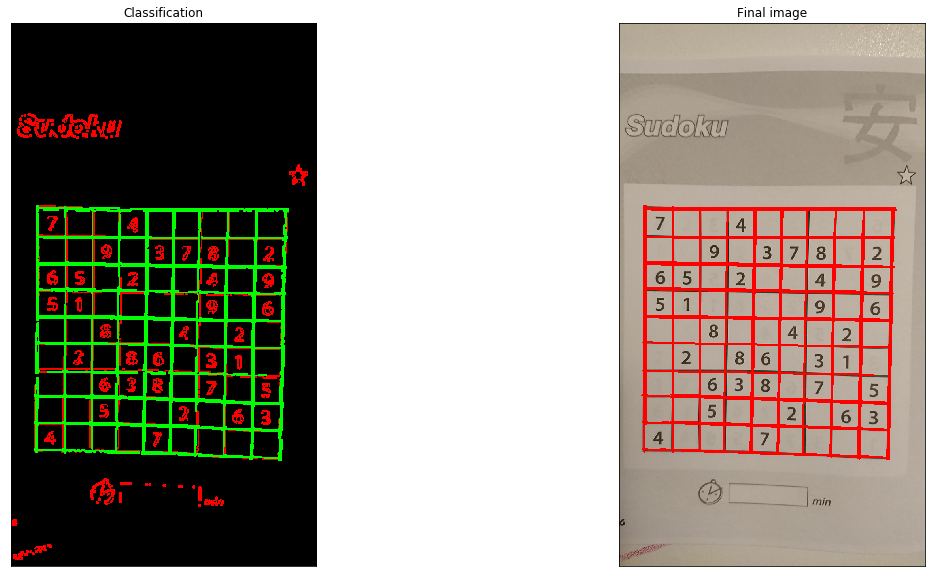

In [149]:
colored = np.zeros((dilated.shape[0], dilated.shape[1], 3), dtype='uint8')

colored[:,:,0] = edges_dilated
colored[:,:,0] -= dilated
colored[:,:,1] = dilated

#cv2.imwrite('sudoku_class.png', cv2.cvtColor(colored, cv2.COLOR_RGB2BGR))
#cv2.imwrite('sudoku_final.png', cv2.cvtColor(img_color, cv2.COLOR_RGB2BGR))

tools.multiPlot(1, 2, (colored, img_color), ('Classification', 'Final image',), cmap_tuple=(cm.gray, cm.gray,))